# Demo for illustrating the relationship between rdp and dp
Subsample type: Poisson subsampling (random subset size)

Key params: 
- subsampling ratio for each individual (example) $q \in [0,1.0]$: a sequence of pre-defined real numbers; 
- noise multiplier `sigma`: the normalized noise level $\varepsilon$, i.e., std of Gaussian noise divided by global L2-norm sensitivity C;
- `delta`: the target DP parameter $\delta$.

# # Theoretical results of Ilya Mironov (opacus)

In [1]:
import sys
sys.path.append('../..')
import numpy as np

from fedrpdp import PrivacyEngine
from fedrpdp.accountants.analysis import rdp as rdp_analysis

privacy_engine = PrivacyEngine(accountant="rdp")

noise_multiplier = 10.0
sample_rate = 1.0
num_steps = 100
delta = 1e-5
alphas = privacy_engine.accountant.DEFAULT_ALPHAS

privacy_engine.accountant.history.append((noise_multiplier, sample_rate, num_steps))
# privacy_engine.get_epsilon(delta=delta)
opt_rdp, opt_alpha = privacy_engine.accountant.get_privacy_spent(delta=delta, alphas=alphas) # use default alphas

../../fedrpdp/myopacus/privacy_engine.py:144: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


In [2]:
rdps = rdp_analysis.compute_rdp(
    q=sample_rate,
    noise_multiplier=noise_multiplier,
    steps=num_steps,
    orders=alphas,
)
alpha_vec = np.atleast_1d(alphas)
rdp_vec = np.atleast_1d(rdps)
eps = (
    rdp_vec
    - (np.log(delta) + np.log(alpha_vec)) / (alpha_vec - 1)
    + np.log((alpha_vec - 1) / alpha_vec)
)

In [3]:
sample_rate_2 = 0.5

privacy_engine_2 = PrivacyEngine(accountant="rdp")
privacy_engine_2.accountant.history.append((noise_multiplier, sample_rate_2, num_steps))
opt_rdp_2, opt_alpha_2 = privacy_engine_2.accountant.get_privacy_spent(delta=delta, alphas=alphas) # use default alphas

rdps_2 = rdp_analysis.compute_rdp(
    q=sample_rate_2,
    noise_multiplier=noise_multiplier,
    steps=num_steps,
    orders=alphas,
)
eps_2 = (
    np.atleast_1d(rdps_2)
    - (np.log(delta) + np.log(alpha_vec)) / (alpha_vec - 1)
    + np.log((alpha_vec - 1) / alpha_vec)
)

# Theoretical results of Wang Yu-Xiang (autodp)

In [10]:
from fedrpdp.autodp.analysis import rdp_acct
from fedrpdp.autodp.mechanisms.mechanism_zoo import GaussianMechanism
mech = GaussianMechanism(sigma=noise_multiplier)
acct = rdp_acct.anaRDPacct()
acct.compose_poisson_subsampled_mechanisms(mech.RenyiDP, sample_rate_2)
acct.build_zeroth_oracle()
rdps_wang = [acct.RDPs[0](alpha)*num_steps for alpha in alphas]
eps_wang = (
    np.atleast_1d(rdps_wang)
    - (np.log(delta) + np.log(alpha_vec)) / (alpha_vec - 1)
    + np.log((alpha_vec - 1) / alpha_vec)
)

Gaussian Mechanism rdp budget: inf
Gaussian Mechanism rdp budget (updated): 0.005


# Vision

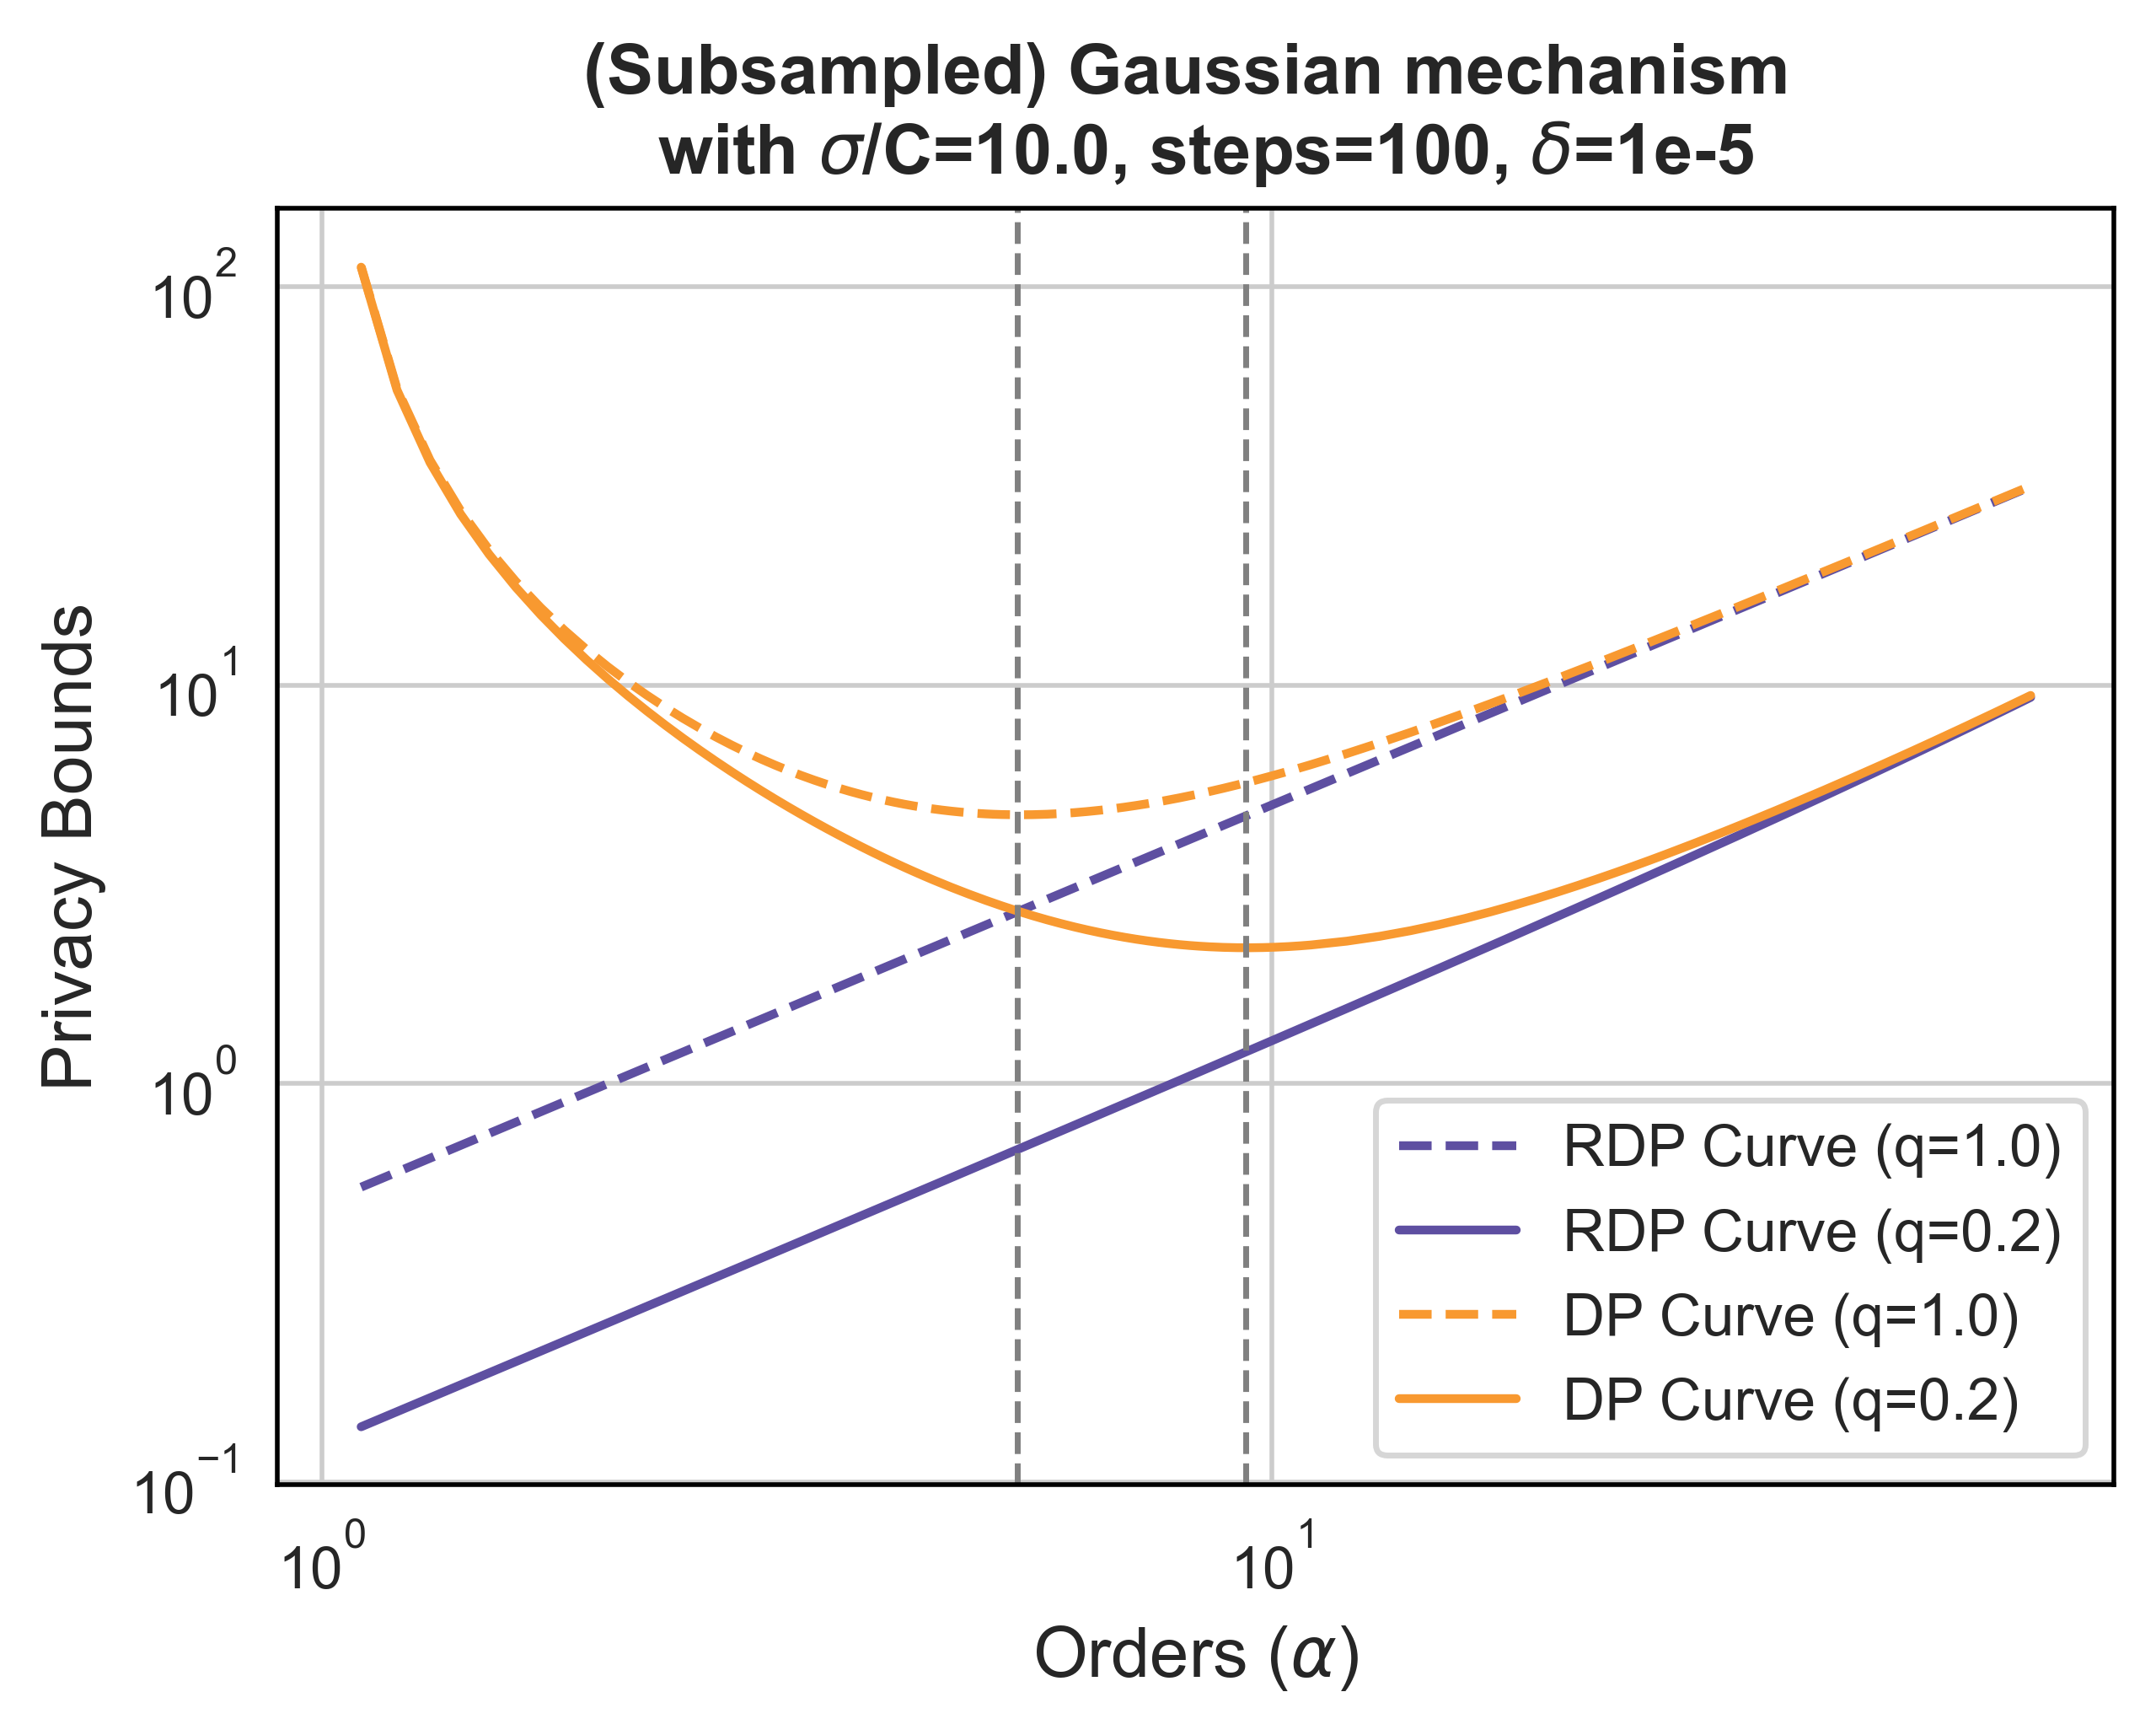

In [12]:
# Vision
import matplotlib.pyplot as plt
import seaborn as sns

plt.close('all')
plt.rcParams['figure.facecolor'] = 'white'
legend_font = {
    'family': 'sans-serif',  # 字体
    'style': 'normal',
    'size': 10,  # 字号
    'weight': "normal",  # 是否加粗，不加粗
}
label_font = {
    'family':'sans-serif',
    'size': 12,  # 字号
}
title_font = {
    'family':'sans-serif',
    'size': 12,  # 字号
    'weight': "bold",  # 是否加粗，不加粗
}

sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'}) #轮廓线
sns.set_palette(palette=sns.color_palette('bright')) #颜色

fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True, dpi=500)

sns.lineplot(x=alphas, y=rdps, color='#5E4FA1', linestyle='--', label=r'RDP Curve (q=1.0)', ax=ax)
sns.lineplot(x=alphas, y=rdps_2, color='#5E4FA1',  label=r'RDP Curve (q=0.2)', ax=ax)
sns.lineplot(x=alphas, y=eps, color='#F89930', linestyle='--', label=r'DP Curve (q=1.0)', ax=ax)
sns.lineplot(x=alphas, y=eps_2, color='#F89930', label=r'DP Curve (q=0.2)', ax=ax)
# sns.lineplot(x=alphas, y=rdps_wang, color='r', linestyle='--', label=r'RDP Curve (q=0.2)', ax=ax)
# sns.lineplot(x=alphas, y=eps_wang, color='r', label=r'DP Curve (q=0.2)', ax=ax)

ax.axvline(x=opt_alpha, linestyle='--', linewidth=1, color='grey')
ax.axvline(x=opt_alpha_2, linestyle='--', linewidth=1, color='grey')

ax.set(xscale="log", yscale="log")
ax.legend(prop=legend_font)
ax.set_ylabel(r'Privacy Bounds', **label_font)
ax.set_xlabel(r'Orders ($\alpha$)', **label_font)

ax.minorticks_on()
ax.tick_params(labelsize=10) #刻度
ax.set_title('(Subsampled) Gaussian mechanism \n with $\sigma$/C=10.0, steps=100, $\delta$=1e-5', **title_font)

plt.savefig('from_rdp_to_dp.pdf', dpi=500, bbox_inches='tight')
plt.show()


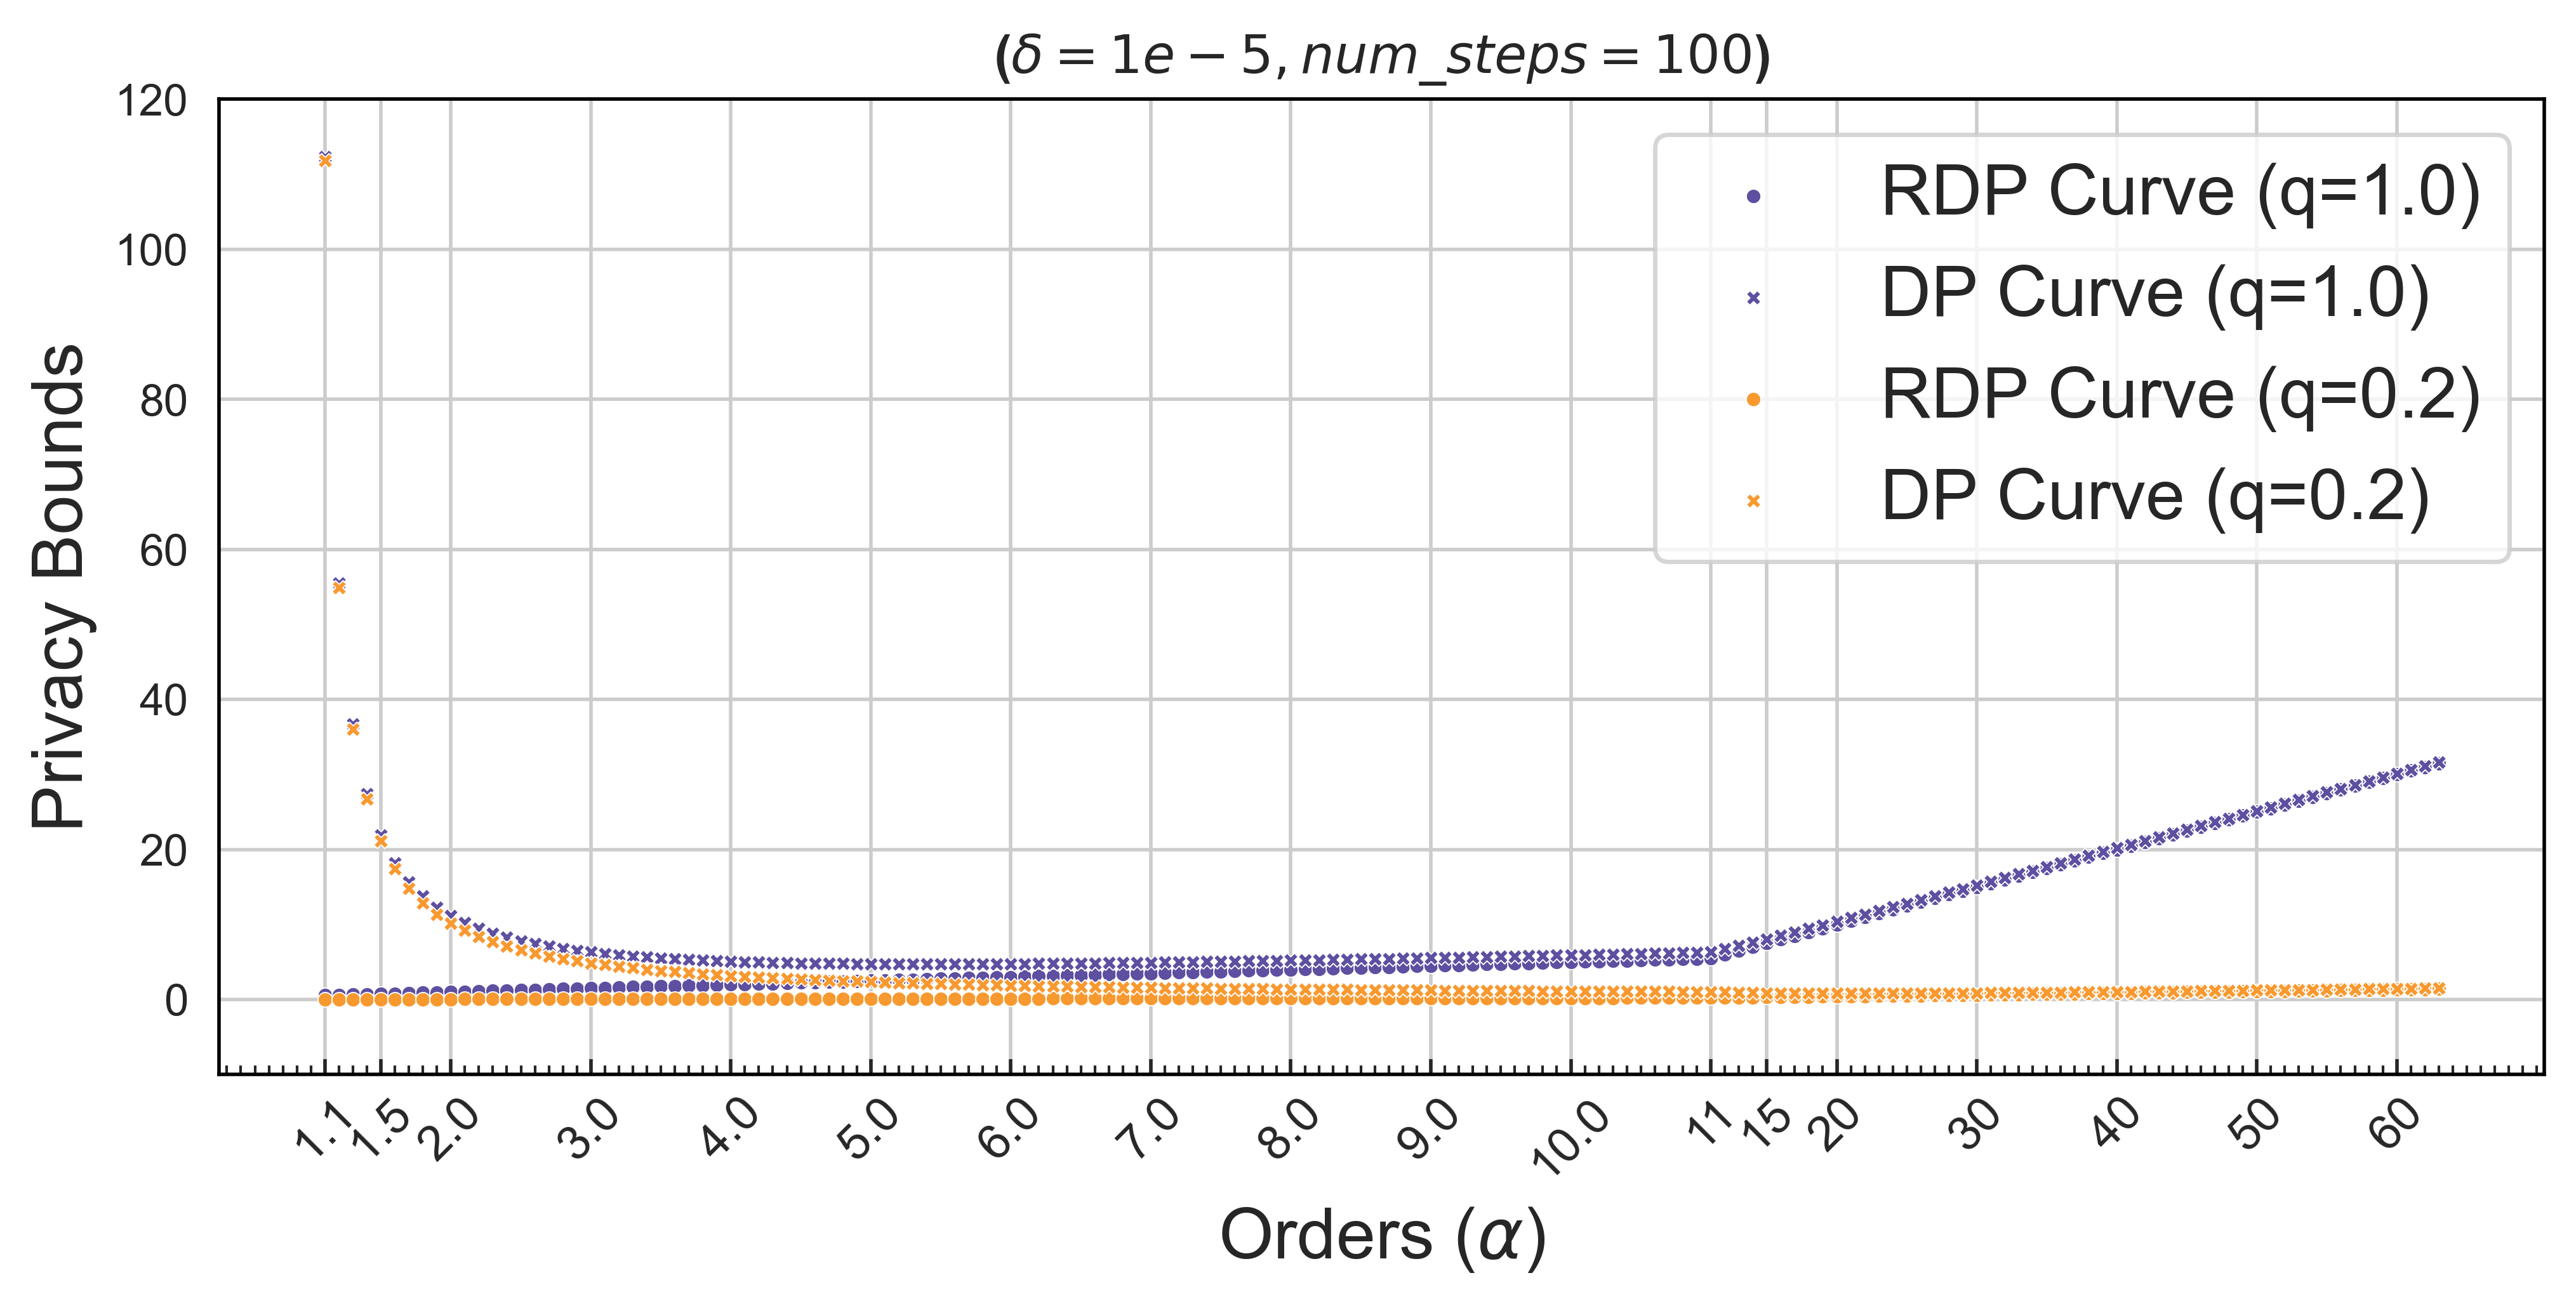

In [ ]:
# Vision
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

plt.close('all')
plt.rcParams['figure.facecolor'] = 'white'
legend_font = {
    'family': 'sans-serif',  # 字体
    'style': 'normal',
    'size': 16,  # 字号
    'weight': "normal",  # 是否加粗，不加粗
}
label_font = {
    'family':'sans-serif',
    'size': 16,  # 字号
}
title_font = {
    'family':'sans-serif',
    'size': 12,  # 字号
    'weight': "bold",  # 是否加粗，不加粗
}

sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'}) #轮廓线
sns.set_palette(palette=sns.color_palette('bright')) #颜色

alphas_str = [str(alpha) for alpha in alphas]
fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True, dpi=500)

sns.scatterplot(x=alphas_str, y=rdps, label=r'RDP Curve (q=1.0)', s=11, ax=ax, color='#5E4FA1')
sns.scatterplot(x=alphas_str, y=eps, marker='X', label=r'DP Curve (q=1.0)', s=11, ax=ax, color='#5E4FA1')
sns.scatterplot(x=alphas_str, y=rdps_2, label=r'RDP Curve (q=0.2)', s=11, ax=ax, color='#F89930')
sns.scatterplot(x=alphas_str, y=eps_2, marker='X', label=r'DP Curve (q=0.2)', s=11, ax=ax, color='#F89930')

ax.legend(prop=legend_font)
ax.set_ylabel(r'Privacy Bounds', **label_font)
ax.set_xlabel(r'Orders ($\alpha$)', **label_font)
ax.set_ylim(-10, 120)

ax.minorticks_on()
ax.xaxis.set_major_locator(plt.FixedLocator([0, 4, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 103, 108, 118, 128, 138, 148]))
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x',reset=False,which='major',direction='in',labelsize=11, rotation=45) #刻度
ax.tick_params(axis='x',reset=False,which='minor',direction='in',labelsize=8) #刻度
ax.set_title(r'($\delta=1e-5, num\_steps=100$)', **title_font)

# plt.savefig('prob_estimation.pdf', dpi=500, bbox_inches='tight')
plt.show()
